# Домашнее задание №3: Facebook Prophet для прогнозирования временных рядов (базовые 0.8 баллов (максимум 1 балл))

<span style="color: red; font-size: 14pt">Дедлайн: 6 сентября 23:59</span>

_Комментарий_: для удобства оценивания в данном задании разбалловка указано в процентном соотношении относительно 1 балла (т.е. бонусные 0.2 балла это 20% в конце задания).

**Оформление дз**: 

- Task short name: ``HW3 Prophet``.
- Выполненное дз сохраните в файл ``ML2018_<фамилия>_HW#.ipynb``, к примеру -- ``ML2018_ivanov_HW3.ipynb``
- Присылайте выполненное задание на почту <a href="mailto:ml4megafon_2018_08@bigdatateam.org"> ml4megafon_2018_08@bigdatateam.org</a> с темой письма `` HW# Short name. ФИО ``. 

    Например: `` HW3 Prophet. Иванов Иван Иванович. ``

**Вопросы**:
- Свои вопросы присылайте в Telegram.

**Фидбек**:
- Пожалуйста, оставьте свой отзыв после выполнения домашнего задания по сссылке:

   http://bit.ly/ml4megafon_august18_hw3prophet_feedback

In [52]:
import numpy as np
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
from matplotlib import gridspec
import pandas as pd
import math
import pandas.tseries.offsets as ofs
from scipy import stats
import statsmodels.api as sm
from statsmodels.tsa import stattools

import warnings as w
import plotly.plotly as py

import scipy.stats as scs
import statsmodels.tsa.api as smt

%matplotlib inline

In [53]:
from fbprophet import Prophet
import logging
logging.getLogger('fbprophet').setLevel(logging.ERROR)
import warnings
warnings.filterwarnings("ignore")

Загрузим данные. Они содержат интервал с пропущенными значениями. Выделим отдельно временной ряд `ts_no_outs` без большого пропуска. По умолчанию будем работать с ним.

In [105]:
ts = pd.read_csv('dataset1_with_outliers_data.csv')
ts.index = pd.to_datetime(ts['ds'])
ts.sort_index(inplace=True)

ts_test = ts[datetime(2015,1,1):]

ts_full = ts[:datetime(2015,1,1)]
ts_no_outs = ts_full[datetime(2012, 1,1):]

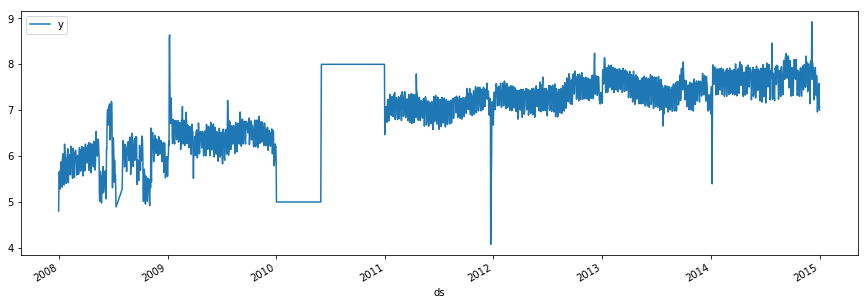

In [106]:
ts_full.plot(figsize=(15,5))

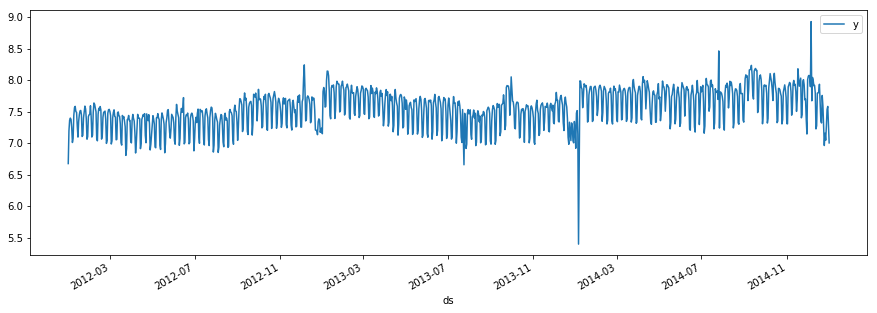

In [107]:
ts_no_outs.plot(figsize=(15,5))

### Часть 0. Разогрев.
Для выполнения этого задания полезно будет просмотреть [вот этот ноутбук](http://nbviewer.jupyter.org/github/Yorko/mlcourse_open/blob/master/jupyter_english/topic09_time_series/topic9_part1_time_series_python.ipynb) и обратиться к [официальной документации](https://facebook.github.io/prophet/docs/quick_start.html) Facebook Prophet.


### Часть 1. Проверка ряда на стационарность (20%)

Проверьте ряд на стационарность (например, с помощью критерия [Дики-Фуллера](https://ru.wikipedia.org/wiki/Тест_Дики_—_Фуллера)). Попробуйте привести его к стационарному виду (с помощью преобразования Бокса-Кокса, дифференцирования etc.)

После получения стационарного ряда напишите функцию прямой `transform` и обратной `inv_transform` трансформации временного ряда (т.е. исходный ряд -> стационарный ряд и стационарный ряд -> исходный ряд).

In [110]:
sm.tsa.stattools.adfuller(ts_no_outs['y'])[1]

0.07417494742311714

In [109]:
sm.tsa.stattools.adfuller(ts_no_outs['y'].diff(1)[1:])[1]

2.854504049051914e-20

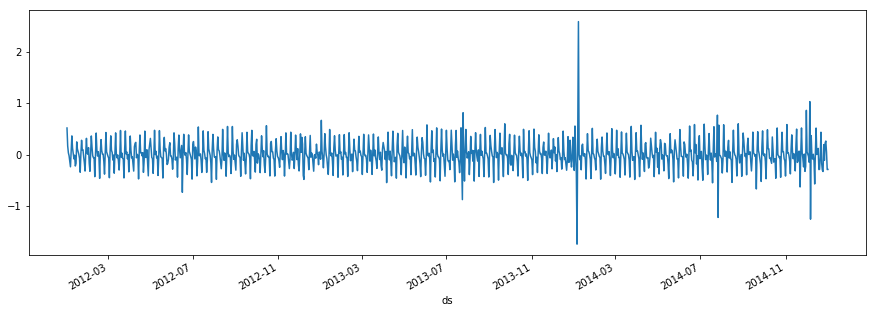

In [111]:
ts_no_outs['y'].diff(1).plot(figsize=(15,5))

In [57]:
def tsplot(y, lags=None, figsize=(12, 7), style='bmh'):
    if not isinstance(y, pd.Series):
        y = pd.Series(y)
    with plt.style.context(style):    
        fig = plt.figure(figsize=figsize)
        layout = (2, 2)
        ts_ax = plt.subplot2grid(layout, (0, 0), colspan=2)
        acf_ax = plt.subplot2grid(layout, (1, 0))
        pacf_ax = plt.subplot2grid(layout, (1, 1))
        

        y.plot(ax=ts_ax)
        ts_ax.set_title('Time Series Analysis Plots')
        smt.graphics.plot_acf(y, lags=lags, ax=acf_ax, alpha=0.5)
        smt.graphics.plot_pacf(y, lags=lags, ax=pacf_ax, alpha=0.5)

        print("Критерий Дики-Фуллера: p=%f" % sm.tsa.stattools.adfuller(y)[1])


        plt.tight_layout()
    return         

In [76]:
#

In [88]:
data = ts_no_outs

In [78]:
#

In [79]:
def fuller(d, n_samples=200, rho=0):
    x = w = d
    for t in range(n_samples):
        x[t] = rho * x[t-1] + w[t]
    
    with plt.style.context('bmh'):  
        plt.figure(figsize=(10, 3))
        plt.plot(x)
        plt.title("Rho {}\n Dickey-Fuller p-value: {}".format(rho, round(sm.tsa.stattools.adfuller(x)[1], 3)))

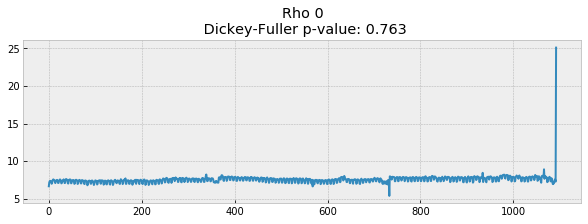

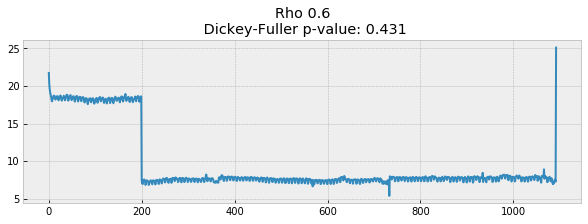

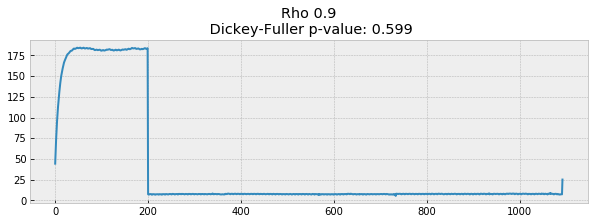

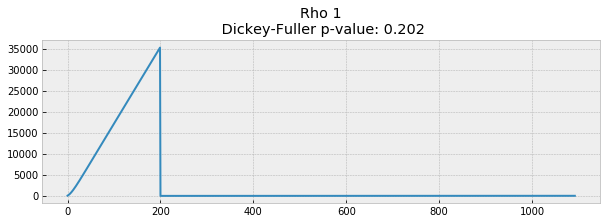

In [80]:
for rho in [0, 0.6, 0.9, 1]:
    fuller(d=data['y'].values,rho=rho)

Критерий Дики-Фуллера: p=0.202060


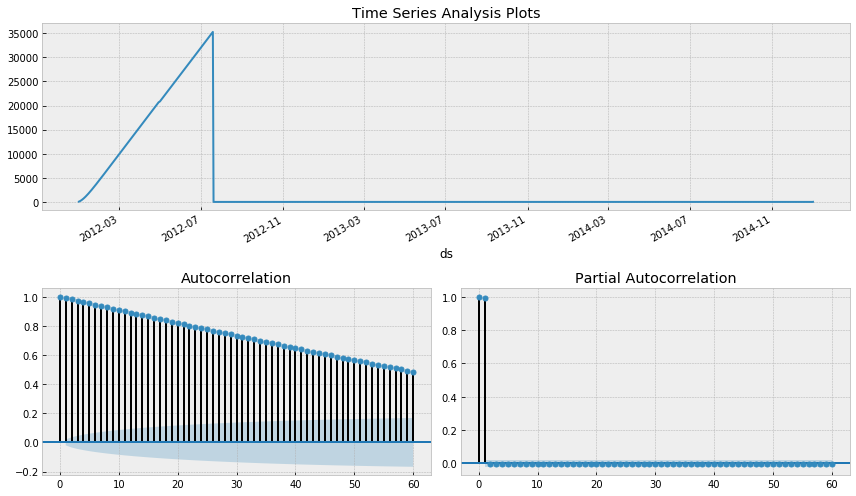

In [96]:
tsplot(data.y, lags=60)

Критерий Дики-Фуллера: p=0.000053


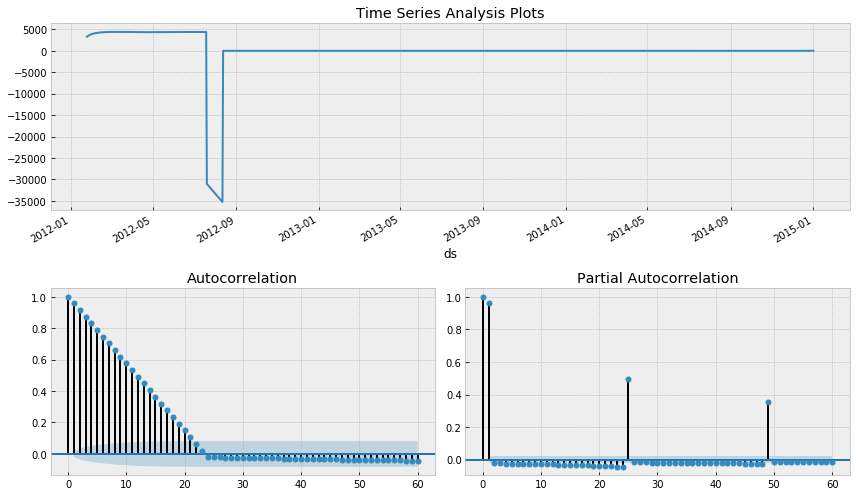

In [95]:
data_diff = data.y - data.y.shift(24)
tsplot(data_diff[24:], lags=60)

In [97]:
d_ = data.copy()
d_bx = scs.boxcox(d_.y)

Критерий Дики-Фуллера: p=0.192769


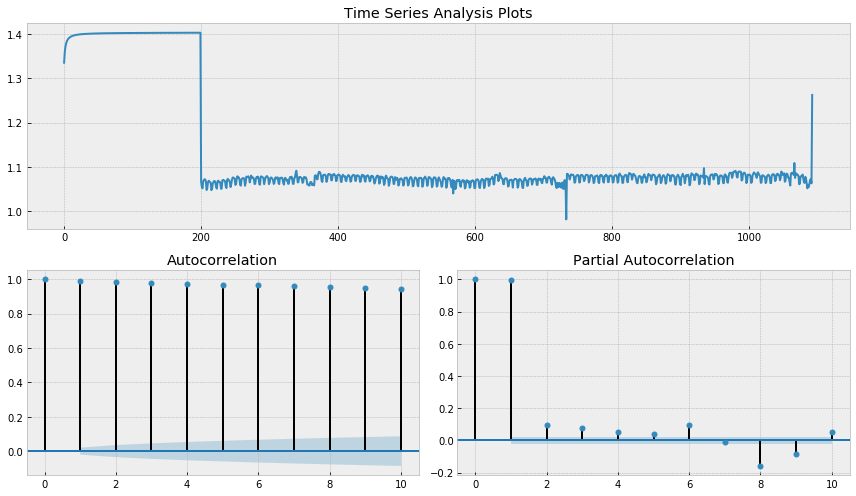

In [98]:
tsplot(d_bx[0], lags=10)

In [ ]:
def transform(ts):
    ### Your code here
    

def inv_transform(ts):
    ### Your code here

### Часть 2. Обнаружение выбросов (10%).
С помощью экспоненциального сглаживания найдите выбросы в данных (и попробуйте их сгладить). Для этого подберите оптимальные значения параметров `alpha`, `beta` и `std_window`. Функция для детекции аномалий и сглаживания приведена ниже. Обратите внимание, мы работаем лишь с `ts_train`, тестовый датасет `ts_test` "находится в будущем" и нам недоступен.

In [ ]:
def exponential_smoothing_anomaly_filter(series, alpha, beta=2.5, std_window=10):
    """
    Anomaly filter based on simple exponential smoothing.

    Parameters
    ----------
    series : pandas.Series
        Time series to smooth.
    alpha : float in range [0., 1.]
        Smoothing parameter. The smaller is `alpha`, the smoother are result series.
    beta: float
        Multiplier for rolling standard deviation. If the deviation from smoothed time series in some point is bigger
        than `beta`*rolling_std, that point is marked as anomaly.
    std_window : int
        Rolling std window width.

    Returns
    -------
    _ : pandas.Series
        Smoothed time series.
    _ : pandas.Series
        Series containing anomalies (both time and value).
    """


    result = [series[0]] # first value is same as series
    sx = series.rolling(std_window).std()
    anomalies_index = []
    anomalies_values = []
#     print(len(series), len(sx))
    for n in range(1, len(series)):
        if n > std_window:
            if abs(series[n] - result[n-1]) > sx[n]*beta:
                result.append(result[n-1])
                anomalies_index.append(series.index[n])
                anomalies_values.append(series[n])
                continue
        result.append(alpha * series[n] + (1 - alpha) * result[n-1])
    return pd.Series(index=series.index, data=result), pd.Series(index=anomalies_index, data=anomalies_values)

In [ ]:
### Your code here

### Часть 3. Построение прогнозов с помощью библиотеки Facebook Prophet (50%)

#### Построение прогноза (25%)

Сделайте предсказание на год вперед на основании `ts_no_outs` и `ts_full`. Для этого вам пригодится функция `make_future_dataframe()`.

In [ ]:
# fmodel = Prophet()
# future = fmodel.make_future_dataframe(periods=365)

### Your code here

Оцените качество прогноза с помощью MSE, MAE и $r^2$-score (т.е. сравните прогноз с реальным поведением временного ряда). Для этого может быть полезна функция `make_comparison_dataframe` (приведенная в [статье](https://medium.com/open-machine-learning-course/open-machine-learning-course-topic-9-part-3-predicting-the-future-with-facebook-prophet-3f3af145cdc)).

In [ ]:
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error

def make_comparison_dataframe(historical, forecast):
    """Join the history with the forecast.
    
       The resulting dataset will contain columns 'yhat', 'yhat_lower', 'yhat_upper' and 'y'.
    """
    return forecast.set_index('ds')[['yhat', 'yhat_lower', 'yhat_upper']].join(historical.set_index('ds'))


### Your code here

Также визуально оцените дисперсию прогноза в случае обучения на `ts_no_outs` и на `ts_full`. 

_Ваш ответ здесь_

#### Автоматическая работа с пропущенными значениями (25%)

На самом деле, библиотека Facebook Prophet умеет работать с пропущенными значениями. Создайте копию `ts_copy` ряда `ts_full` и замените в ней значения с 2010-01-01 по 2011-01-01 на `None`.

In [ ]:
ts_copy = ts_full.copy()

### Your code here

Снова постройте прогноз на год вперед, но теперь на основании `ts_copy`.

In [ ]:
### Your code here

Оцените качество прогноза с помощью MSE, MAE и $r^2$-score. Стал ли прогноз лучше? Что стало с дисперсие прогноза?

In [ ]:
### Your code here

_Ваш ответ здесь_

#### Добавление информации о выходных днях.
Добавьте информацию о выходных днях (суббота и воскресенье). Для этого может быть полезен [вот этот ноутбук](https://github.com/facebook/prophet/blob/master/notebooks/seasonality%2C_holiday_effects%2C_and_regressors.ipynb) в качестве примера (`lower_window` и `upper_window` нам неактуальны, т.к. выходные не имеют локального влияния). 

_Обращаем ваше внимание: если не указать даты особых дней в будущем (т.е. внутри горизонта прогнозирования), то они не будут использованы при построении прогноза. Т.е. нужно указывать и даты в будущем_.

In [ ]:
saturdays  = pd.DataFrame({
  'holiday': 'saturday',
  'ds': ts.loc[ts.index.weekday == 5].ds### Your code here
})


sundays  = pd.DataFrame({
  'holiday': 'sunday',
  'ds': ts.loc[ts.index.weekday == 6].ds
})

### Your code here

Постройте прогноз на год вперед c учетом выходных дней на основании `ts_copy` (с которым мы работали до этого).

In [ ]:
### Your code here

Оцените качество прогноза с помощью MSE, MAE и $r^2$-score. Стал ли прогноз лучше? Что стало с дисперсие прогноза?

In [ ]:
### Your code here

#### Опциональные эксперименты (это опциональная часть, делать ее необязательно, бонус до 0.2 баллов).
Временной ряд, с которым мы работаем, описывает количество обращений к фиксированной статье в Википедии. Вы можете попробовать добавить информацию о международных праздниках и некоторых значимых событиях; попробовать применить некоторые другие возможности библиотеки Facebook Prophet. Любые идеи на ваш вкус :)

In [ ]:
### Your optional code here

Пожалуйста, оставьте отзыв о домашнем задании: [link](http://bit.ly/ml4megafon_august18_hw3prophet_feedback)